# Data Gathering

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/imsparsh/audio-speech-sentiment/')
od.download('https://www.kaggle.com/datasets/uldisvalainis/audio-emotions')
# requires kaggle credentials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nathanielss
Your Kaggle Key: ··········


100%|██████████| 231M/231M [00:03<00:00, 65.9MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nathanielss
Your Kaggle Key: ··········


100%|██████████| 1.12G/1.12G [00:11<00:00, 106MB/s] 


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import librosa
import numpy as np
import os

# Set the paths to the dataset and CSV file
dataset_path = 'audio-speech-sentiment/TRAIN'
csv_path = 'audio-speech-sentiment/TRAIN.csv'

# Load the CSV file with labels
data_df = pd.read_csv(csv_path)

# Define the function to extract MFCC features
def extract_features(audio, sr):
    # Compute MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr)
    # Flatten the MFCC matrix
    mfcc_flat = mfcc.flatten()
    # Return the flattened MFCC features
    return mfcc_flat

# Define the function to load and preprocess audio files
def preprocess_audio(audio_path):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=None)
    # Normalize the audio using librosa
    max_amp = np.max(np.abs(audio))
    normalized_x = audio / max_amp

    # Trim the audio
    xt, index = librosa.effects.trim(normalized_x, top_db=30)

    # Pad the audio if necessary
    final_x = np.pad(xt, (0, 320000 - len(xt)), 'constant')

    # Perform feature extraction using MFCCs
    features = extract_features(final_x, sr)

    return features

In [ ]:
# audio_speech_sentiment
data = []
data1 = []
for index, row in data_df.iterrows():
    filename = row['Filename']
    label = row['Class']
    audio_path = f"{dataset_path}/{filename}"
    features = preprocess_audio(audio_path)
    data.append((features, label))
    data1.append((features, label))

# audio_emotions
emotions = {
    'Angry': 'Negative',
    'Disgusted': 'Negative',
    'Fearful': 'Negative',
    'Happy': 'Positive',
    'Neutral': 'Neutral',
    'Sad': 'Negative',
    'Suprised': 'Neutral'
}
emot_path = '/content/audio-emotions/Emotions'

for i in os.listdir(emot_path):
  audio_path_emotion = f"{emot_path}/{i}"
  print(audio_path_emotion)
  for j in os.listdir(audio_path_emotion):
    testing = f"{audio_path_emotion}/{j}"
    features = []
    label = emotions.get(i)
    features = preprocess_audio(testing)
    data.append((features, label))

/content/audio-emotions/Emotions/Suprised
/content/audio-emotions/Emotions/Fearful
/content/audio-emotions/Emotions/Disgusted
/content/audio-emotions/Emotions/Neutral
/content/audio-emotions/Emotions/Happy
/content/audio-emotions/Emotions/Sad


<ipython-input-3-2c88bbbe8aea>:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_x = audio / max_amp


/content/audio-emotions/Emotions/Angry


#Training model

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X=[item[0] for item in data]
y=[item[1] for item in data]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
from keras.utils import pad_sequences
max_length = max(len(item) for item in x_train + x_test)
x_train = pad_sequences(x_train, maxlen=max_length, dtype='float32', padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, dtype='float32', padding='post', truncating='post')

In [ ]:
# Encode the target data as one-hot vectors
from keras.utils import to_categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
# Define the model architecture
model = Sequential()
model.add(Dense(256, activation='LeakyReLU', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='LeakyReLU'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='LeakyReLU'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='LeakyReLU'))
model.add(Dropout(0.2))
# model.add(Dense(64, activation='LeakyReLU'))
# model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3205376   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train the model
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
327/327 [==============================] - 14s 12ms/step - loss: 39.6641 - accuracy: 0.4920 - val_loss: 4.5561 - val_accuracy: 0.6483
Epoch 2/50
327/327 [==============================] - 4s 11ms/step - loss: 8.3581 - accuracy: 0.5338 - val_loss: 1.6145 - val_accuracy: 0.6992
Epoch 3/50
327/327 [==============================] - 3s 10ms/step - loss: 5.3408 - accuracy: 0.5322 - val_loss: 1.4698 - val_accuracy: 0.6828
Epoch 4/50
327/327 [==============================] - 3s 9ms/step - loss: 3.3037 - accuracy: 0.5565 - val_loss: 0.8587 - val_accuracy: 0.6977
Epoch 5/50
327/327 [==============================] - 2s 5ms/step - loss: 2.3351 - accuracy: 0.5727 - val_loss: 0.8866 - val_accuracy: 0.6962
Epoch 6/50
327/327 [==============================] - 2s 5ms/step - loss: 1.5965 - accuracy: 0.5931 - val_loss: 0.7301 - val_accuracy: 0.7192
Epoch 7/50
327/327 [==============================] - 2s 5ms/step - loss: 1.0929 - accuracy: 0.6362 - val_loss: 0.6859 - val_accuracy: 0.7253
E

In [ ]:
# Percobaan

# Extract the training metrics
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Create a dictionary with the metrics
metrics = {
    'epoch': epochs,
    'loss': loss,
    'accuracy': accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
}

# Create a DataFrame from the metrics dictionary
df = pd.DataFrame(metrics)
df

epoch       loss  accuracy  val_loss  val_accuracy
0       1  39.664112  0.491952  4.556056      0.648276
1       2   8.358122  0.533819  1.614450      0.699234
2       3   5.340787  0.532190  1.469829      0.682759
3       4   3.303743  0.556524  0.858737      0.697701
4       5   2.335099  0.572715  0.886557      0.696169
5       6   1.596456  0.593121  0.730058      0.719157
6       7   1.092925  0.636233  0.685948      0.725287
7       8   0.869360  0.669285  0.713815      0.723372
8       9   0.769940  0.692470  0.701637      0.726820
9      10   0.709638  0.712205  0.684835      0.730268
10     11   0.682893  0.725043  0.684682      0.736782
11     12   0.674243  0.731270  0.675849      0.727586
12     13   0.675577  0.730025  0.661199      0.727586
13     14   0.677707  0.730791  0.674821      0.731418
14     15   0.668959  0.731845  0.689058      0.731034
15     16   0.675673  0.727726  0.708148      0.715326
16     17   0.678009  0.728492  0.670201      0.726054
17     18   0.689291  0.726959  0.729458      0.718008
18     19   0.691440  0.723223  0.715203      0.703831
19     20   0.684680  0.724756  0.724518      0.702299
20     21   0.689036  0.722840  0.695531      0.717241
21     22   0.688812  0.727151  0.724241      0.708812
22     23   0.720830  0.708086  0.661892      0.728352
23     24   0.685122  0.720828  0.868334      0.680077
24     25   0.683113  0.725235  0.659211      0.731801
25     26   0.675637  0.727055  0.675733      0.730268
26     27   0.675525  0.733378  0.672729      0.724904
27     28   0.703844  0.714888  0.742521      0.712261
28     29   0.706799  0.718624  0.679777      0.727969
29     30   0.667650  0.728779  0.651547      0.737165
30     31   0.666093  0.734144  0.698379      0.731418
31     32   0.658742  0.732612  0.655067      0.732567
32     33   0.676626  0.727917  0.680201      0.732184
33     34   0.688227  0.724756  0.665968      0.739080
34     35   0.671730  0.729642  0.732123      0.726820
35     36   0.645913  0.737114  0.661117      0.737165
36     37   0.626087  0.747270  0.688267      0.736015
37     38   0.636671  0.745545  0.730848      0.715326
38     39   0.655776  0.738551  0.751019      0.709195
39     40   0.638773  0.740755  0.688301      0.729119
40     41   0.626817  0.748036  0.656895      0.729885
41     42   0.627737  0.746886  0.703554      0.722988
42     43   0.621013  0.746120  0.656731      0.739464
43     44   0.603317  0.753784  0.654883      0.736398
44     45   0.601897  0.752347  0.665027      0.738314
45     46   0.607674  0.757042  0.664429      0.735632
46     47   0.600280  0.752922  0.664363      0.733716
47     48   0.610893  0.749377  0.627146      0.742146
48     49   0.599206  0.754646  0.656291      0.739080
49     50   0.586167  0.756467  0.708847      0.734483

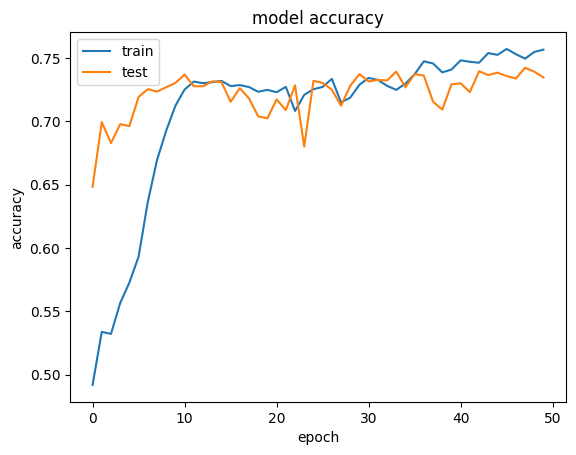

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

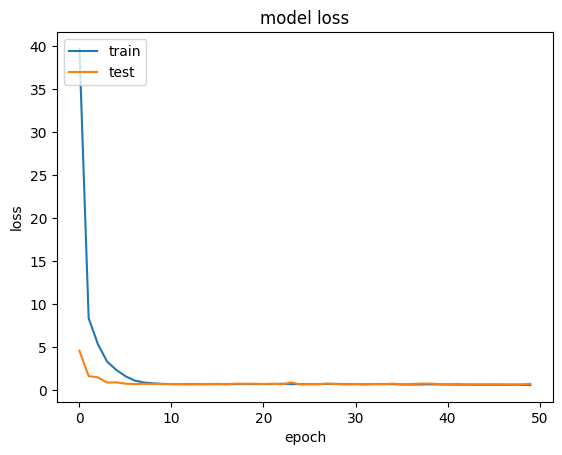

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

82/82 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.7345
Test loss: 0.7088
Test accuracy: 0.7345


In [ ]:
def reverse(onehot):
  return np.argmax(onehot, axis=None, out=None)

In [ ]:
pred = np.round(model.predict(x_test))
pred_int = []
for i in pred:
  pred_int.append(reverse(i))
pred_int

y_test_int = []
for i in y_test:
  y_test_int.append(reverse(i))

82/82 [==============================] - 0s 2ms/step


Text(50.722222222222214, 0.5, 'predicted')

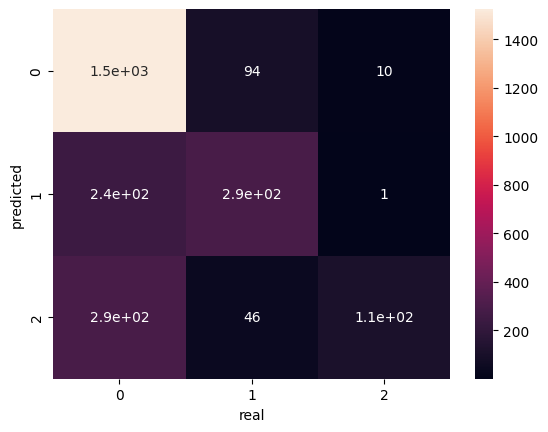

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test_int, pred_int), annot=True)
plt.xlabel('real')
plt.ylabel('predicted')

In [ ]:
label_encoder.inverse_transform([0])

array(['Negative'], dtype='<U8')

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Assuming you have a single audio file to predict the sentiment
audio_path = '/content/audio-speech-sentiment/TRAIN/346.wav'
features = preprocess_audio(audio_path)
features = np.expand_dims(features, axis=0)
# features[0].shape
predictions = model.predict(features)
label_encoder.inverse_transform([reverse(predictions)])

1/1 [==============================] - 0s 39ms/step


array(['Negative'], dtype='<U8')

Coba-coba

In [ ]:
import pandas as pd
from IPython.display import Audio, display

In [ ]:
df_label = pd.read_csv('/content/audio-speech-sentiment/TRAIN.csv')

In [ ]:
def predict_sentiment(audio_path):
  features = preprocess_audio(audio_path)
  features = np.expand_dims(features, axis=0)
  predictions = model.predict(features)
  label = label_encoder.inverse_transform([reverse(predictions)])
  print(label)

In [ ]:
audio_path1 = '/content/audio-speech-sentiment/TRAIN/305.wav'
display(Audio(audio_path1))

In [ ]:
actual_label1 = df_label[df_label['Filename'] == '305.wav']['Class']
actual_label1

14    Negative
Name: Class, dtype: object

In [ ]:
predict_sentiment(audio_path1)

1/1 [==============================] - 0s 26ms/step
['Negative']


In [ ]:
audio_path2 = '/content/audio-speech-sentiment/TRAIN/29.wav'
display(Audio(audio_path2))

In [ ]:
actual_label2 = df_label[df_label['Filename'] == '29.wav']['Class']
print(actual_label2)

118    Positive
Name: Class, dtype: object


In [ ]:
predict_sentiment('/content/audio-speech-sentiment/TRAIN/29.wav')

1/1 [==============================] - 0s 52ms/step
['Positive']


In [ ]:
audio_path3 = '/content/audio-speech-sentiment/TRAIN/155.wav'
display(Audio(audio_path3))

In [ ]:
actual_label3 = df_label[df_label['Filename'] == '155.wav']['Class']
print(actual_label3)

219    Neutral
Name: Class, dtype: object


In [ ]:
predict_sentiment('/content/audio-speech-sentiment/TRAIN/155.wav')

1/1 [==============================] - 0s 26ms/step
['Neutral']
